<a href="https://colab.research.google.com/github/Rakshu0308/DL1-2/blob/main/DL1_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U datasets


In [ ]:
from datasets import load_metric
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/code cycle/wikihow (9).csv")
df.head()

,Article Title,Subheading,Paragraph
0,Sample Article Title,Example Heading 1,Example paragraph 1.
1,Sample Article Title,Example Heading 2,Example paragraph 2.
2,3 Ways to Make a Leave in Hair Conditioner - w...,Mix up a simple sprayable conditioner with wat...,Fill a spray bottle with 1 cups (300 millilite...
3,3 Ways to Make a Leave in Hair Conditioner - w...,Create a moisturizing conditioner by adding wa...,Combine the ingredients listed below in a spra...
4,3 Ways to Make a Leave in Hair Conditioner - w...,Add some aloe vera and coconut oil if you want...,Pour the ingredients listed below into a spray...


In [ ]:
print(df.shape)
df=df.dropna()
print(df.shape)


(213, 3)
(213, 3)


In [ ]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)


(211, 3)
(211, 3)


In [ ]:
df['length'] = df['Article Title'].map(lambda x: len(x.split(" ")))



In [ ]:
import matplotlib

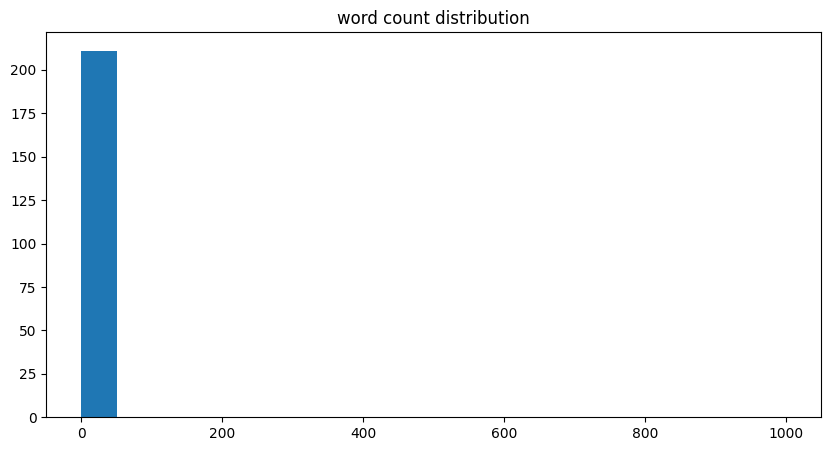

In [ ]:
numOfWords=df.length
from matplotlib import pyplot as plt
fig=plt.figure(figsize =(10,5))
plt.hist(numOfWords.to_numpy(), bins=[0,50,100,200,300,500,1000])
plt.title("word count distribution")
plt.show()


In [ ]:
tempDf=df[df['length']<100]
tempDf.shape

(211, 4)

In [ ]:
pip install transformers


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
import numpy  as np
train,validate,test=np.split(tempDf.sample(frac=1,random_state=42),[int(.8*len(tempDf)),int(.9*len(tempDf))])
print(train.shape)
print(validate.shape)
print(test.shape)

(168, 4)
(21, 4)
(22, 4)


In [ ]:
validate= validate[:20]
validate.shape

(20, 4)

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
validate_dataset = Dataset.from_pandas(validate)
test_dataset = Dataset.from_pandas(test)

In [ ]:
train_dataset=train_dataset.map(process_data_to_model_inputs,batched=True,batch_size=batch_size,remove_columns=["Article Title","Paragraph"]) # Changed "Text" to "Paragraph" assuming that is the correct column name
validate_dataset=validate_dataset.map(process_data_to_model_inputs,batched=True,batch_size=batch_size,remove_columns=["Article Title","Paragraph"]) # Changed "Text" to "Paragraph" assuming that is the correct column name
test_dataset=test_dataset.map(process_data_to_model_inputs,batched=True,batch_size=batch_size,remove_columns=["Article Title","Paragraph"]) # Changed "Text" to "Paragraph" assuming that is the correct column

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

In [ ]:
# Import the necessary libraries from transformers
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_metric

# Load the LED (Longformer Encoder-Decoder) model with specific configurations
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

# Configure the model's decoding parameters
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 10
led.config.length_penalty = -2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

# Load the ROUGE metric for evaluation
rouge = load_metric("rouge")

# Define a function to compute metrics for evaluation
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predicted and label sequences
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels_ids]
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute the ROUGE score
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])

    # Return the precision, recall, and f-measure for ROUGE-2
    return {
        "rouge2_precision": round(rouge_output["rouge2"].precision, 4),
        "rouge2_recall": round(rouge_output["rouge2"].recall, 4),
        "rouge2_fmeasure": round(rouge_output["rouge2"].fmeasure, 4),
    }

# Setup training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",  # Directory to store model outputs
    evaluation_strategy="steps",  # Evaluation after a set number of steps
    per_device_train_batch_size=8,  # Adjust based on memory constraints
    per_device_eval_batch_size=8,   # Adjust based on memory constraints
    logging_steps=5,  # How often to log progress
    eval_steps=18,  # Perform evaluation every 18 steps
    save_steps=18,  # Save the model every 18 steps
    save_total_limit=2,  # Limit the total number of saved checkpoints
    gradient_accumulation_steps=4,  # Accumulate gradients over multiple steps
    num_train_epochs=20,  # Number of training epochs

)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=db130d203b82c1f2e556a33289a9c58553012ea4b5b70da872935a1f3a292044
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset, load_metric

# Load the dataset with a specified configuration and metric
dataset = load_dataset("cnn_dailymail", "3.0.0")  # Specify configuration here
rouge = load_metric("rouge")

# Load the LED (Longformer Encoder-Decoder) model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384")
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

# Preprocessing function
def preprocess_function(examples):
    inputs = examples["article"]
    targets = examples["highlights"]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]

    # Create global_attention_mask with 2s for global attention on the first token
    global_attention_mask = [2] + [0] * (len(model_inputs.input_ids[0]) - 1)
    model_inputs["global_attention_mask"] = [global_attention_mask] * len(model_inputs.input_ids)

    # Use global_attention_mask as attention_mask
    model_inputs["attention_mask"] = model_inputs["global_attention_mask"]

    return model_inputs

# Apply preprocessing to the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Split the dataset into train, validation, and test sets
train_dataset = tokenized_dataset["train"]
validate_dataset = tokenized_dataset["validation"]
test_dataset = tokenized_dataset["test"]

# Define a function to compute metrics for evaluation
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predicted and label sequences
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels_ids]
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute the ROUGE score
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])

    # Return the precision, recall, and f-measure for ROUGE-2
    return {
        "rouge2_precision": round(rouge_output["rouge2"].precision, 4),
        "rouge2_recall": round(rouge_output["rouge2"].recall, 4),
        "rouge2_fmeasure": round(rouge_output["rouge2"].fmeasure, 4),
    }

# Setup training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    predict_with_generate=True,
    evaluation_strategy="steps",
    do_train=True,
    do_eval=True,
    logging_steps=500,  # Set to 500 for larger datasets
    save_steps=500,  # Set to 500 for larger datasets
    eval_steps=500,  # Set to 500 for larger datasets
    warmup_steps=2000,  # Set to 2000 for larger datasets
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True,
)

# Create a Trainer instance with the modified arguments
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Input ids are automatically padded from 614 to 1024 to be a multiple of `config.attention_window`: 1024


AssertionError: Sequence length should be multiple of 1024. Given 1357

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd

# Create a sample DataFrame (replace this with your actual df)
data = {'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'col2': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
df = pd.DataFrame(data)

# Shuffle and split the data into train, validate, and test sets
train_size = 0.6
test_size = 0.2
validate_size = 0.2

# Ensure train_size + validate_size + test_size = 1
assert np.isclose(train_size + validate_size + test_size, 1.0), "The sizes should sum up to 1"

# Split data
train_val, test = train_test_split(df, test_size=test_size, random_state=42)
train, validate = train_test_split(train_val, test_size=validate_size / (1 - test_size), random_state=42)

print(f"Train shape: {train.shape}")
print(f"Validate shape: {validate.shape}")
print(f"Test shape: {test.shape}")

# Check some validation samples
print(validate.head(20))
print(f"Validate shape (after checking samples): {validate.shape}")

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)
test_dataset = Dataset.from_pandas(test)  # Ensure to also convert the test set


Train shape: (6, 2)
Validate shape: (2, 2)
Test shape: (2, 2)
   col1  col2
0     1    11
4     5    15
Validate shape (after checking samples): (2, 2)


In [ ]:
!pip install transformers
import transformers  # Add this line to import the transformers module

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_metric

# Load the LED model with gradient checkpointing enabled and set cache
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

# Configure the model for generation
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

# Load the ROUGE metric
rouge = load_metric("rouge")

# Define the function to compute metrics during evaluation
def compute_metrics(pred):
    # Get the labels and predictions
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids = [[label for label in label_ids if label != -100] for label_ids in labels_ids]
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute the ROUGE metric
    rouge_output = rouge.compute(
        predictions=pred_str,
        references=label_str,
        rouge_types=["rouge2"]
    )["rouge2"]

    # Return the formatted metrics
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

# Set training arguments
batch_size = 4  # Example batch size; adjust as needed
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./output_dir",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,  # Example for short training; increase for real training
)

# Enable logging
transformers.logging.set_verbosity_info()

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=led,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_

ValueError: No columns in the dataset match the model's forward method signature. The following columns have been ignored: [col1, col2, __index_level_0__]. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

In [ ]:
import transformers
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_metric, Dataset

# Load the LED model with gradient checkpointing enabled and set cache
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

# Load the ROUGE metric
rouge = load_metric("rouge")

# Define the function to compute metrics during evaluation
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids = [[label for label in label_ids if label != -100] for label_ids in labels_ids]
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"]

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

# Set training arguments
batch_size = 4
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./output_dir",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    remove_unused_columns=False,  # Add this line
)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=led,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0

ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided ['col1', 'col2', '__index_level_0__']

In [ ]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Create a larger sample DataFrame (replace this with your actual df)
data = {
    'Article Title': ["Sample article text"] * 100,
    'Paragraph': ["Sample paragraph text"] * 100
}
df = pd.DataFrame(data)

# Split data into train, validate, and test sets
train, temp = train_test_split(df, test_size=0.4, random_state=42)
validate, test = train_test_split(temp, test_size=0.5, random_state=42)

print(f"Train shape: {train.shape}")
print(f"Validate shape: {validate.shape}")
print(f"Test shape: {test.shape}")

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)
test_dataset = Dataset.from_pandas(test)



Train shape: (60, 2)
Validate shape: (20, 2)
Test shape: (20, 2)


In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

def preprocess_function(examples):
    # Tokenize the inputs and targets
    inputs = tokenizer(examples["Article Title"], max_length=1024, truncation=True, padding="max_length")
    targets = tokenizer(examples["Paragraph"], max_length=64, truncation=True, padding="max_length")

    # Add inputs and targets to dataset
    inputs["labels"] = targets["input_ids"]

    return inputs

# Apply preprocessing
tokenized_dataset = Dataset.from_pandas(df).map(preprocess_function, batched=True)
train_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)['train']
val_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)['test']


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, set_seed
from datasets import load_metric

# Load the LED model
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384")

# Load the ROUGE metric
rouge = load_metric("rouge")

def compute_metrics(pred):
    pred_ids = pred.predictions
    labels_ids = pred.label_ids

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=labels_str, rouge_types=["rouge2"])["rouge2"]

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./output_dir",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    logging_steps=10,
    save_steps=10,
    eval_steps=10,
    num_train_epochs=1,
    remove_unused_columns=False
)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`Article Title` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

def preprocess_function(examples):
    inputs = tokenizer(examples["Article Title"],
                       max_length=1024,
                       truncation=True,
                       padding="max_length",
                       return_tensors='pt')

    targets = tokenizer(examples["Paragraph"],
                        max_length=64,
                        truncation=True,
                        padding="max_length",
                        return_tensors='pt')

    inputs["labels"] = targets["input_ids"]

    return {
        "input_ids": inputs["input_ids"].squeeze().tolist(),  # Convert tensors to lists
        "attention_mask": inputs["attention_mask"].squeeze().tolist(),  # Convert tensors to lists
        "labels": inputs["labels"].squeeze().tolist()  # Convert tensors to lists
    }


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

def preprocess_function(examples):
    inputs = tokenizer(examples["Article Title"],
                       max_length=1024,
                       truncation=True,
                       padding="max_length",
                       return_tensors='pt')

    targets = tokenizer(examples["Paragraph"],
                        max_length=64,
                        truncation=True,
                        padding="max_length",
                        return_tensors='pt')

    inputs["labels"] = targets["input_ids"]

    return {
        "input_ids": inputs["input_ids"].squeeze().tolist(),  # Convert tensors to lists
        "attention_mask": inputs["attention_mask"].squeeze().tolist(),  # Convert tensors to lists
        "labels": inputs["labels"].squeeze().tolist()  # Convert tensors to lists
    }


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

def preprocess_function(examples):
    # Tokenize the inputs and targets
    inputs = tokenizer(examples["Article Title"], max_length=1024, truncation=True, padding="max_length")
    targets = tokenizer(examples["Paragraph"], max_length=64, truncation=True, padding="max_length")

    # Add inputs and targets to dataset
    inputs["labels"] = targets["input_ids"]

    return inputs

# Apply preprocessing
tokenized_dataset = Dataset.from_pandas(df).map(preprocess_function, batched=True)
train_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)['train']
val_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)['test']


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
from datasets import Dataset

# Example DataFrame
import pandas as pd
data = {
    'Article Title': ['Sample article 1', 'Sample article 2'],
    'Paragraph': ['Sample paragraph 1', 'Sample paragraph 2']
}
df = pd.DataFrame(data)

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)

# Apply preprocessing function
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [ ]:
from datasets import Dataset

# Example DataFrame (replace this with your actual DataFrame)
import pandas as pd
data = {
    'Article Title': ['Sample article 1', 'Sample article 2'],
    'Paragraph': ['Sample paragraph 1', 'Sample paragraph 2']
}
df = pd.DataFrame(data)

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)

# Split dataset into train and validation sets
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
validate_dataset = Dataset.from_pandas(validate_df)

# Apply preprocessing function
train_dataset = train_dataset.map(preprocess_function, batched=True)
validate_dataset = validate_dataset.map(preprocess_function, batched=True)



Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Set training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./output_dir",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    eval_strategy="steps",
    logging_steps=10,
    eval_steps=10,
    save_steps=10,
    save_total_limit=1,
    gradient_accumulation_steps=1,
    num_train_epochs=1,
    remove_unused_columns=False
)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,  # Ensure this is defined
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1
  Number of trainable parameters = 161,844,480


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`Article Title` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
# Install required packages
!pip install transformers datasets

# Import necessary libraries
import pandas as pd
from datasets import Dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.model_selection import train_test_split

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

# Define the preprocessing function
def preprocess_function(examples):
    # Tokenize inputs and targets
    inputs = tokenizer(examples["Article Title"], max_length=1024, truncation=True, padding='max_length')
    targets = tokenizer(examples["Paragraph"], max_length=64, truncation=True, padding='max_length')

    # Set labels (targets) to the same length as inputs
    inputs["labels"] = targets["input_ids"]

    # Replace padding token id's of the labels by -100 so it's ignored by the loss
    inputs["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label] for label in inputs["labels"]
    ]

    return inputs

# Create a sample DataFrame (replace this with your actual data)
data = {
    'Article Title': ['Sample article 1', 'Sample article 2'],
    'Paragraph': ['Sample paragraph 1', 'Sample paragraph 2']
}
df = pd.DataFrame(data)

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Split dataset into train and validation
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
validate_dataset = Dataset.from_pandas(validate_df)

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True)
validate_dataset = validate_dataset.map(preprocess_function, batched=True)

# Load the ROUGE metric
rouge = load_metric("rouge")

# Define the function to compute metrics
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids = [[label for label in label_ids if label != -100] for label_ids in labels_ids]
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute the ROUGE metric
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"]

    # Return the formatted metrics
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

# Set training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=4,  # Adjust based on memory
    per_device_eval_batch_size=4,   # Adjust based on memory
    output_dir="./output_dir",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,  # Example for short training; increase for real training
)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--led-base-16384/snapshots/38335783885b338d93791936c54bb4be46bebed9/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: Article Title, __index_level_0__, Paragraph. If Article Title, __index_level_0__, Paragraph are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, d

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from datasets import Dataset

# Sample paragraph
sample_paragraph = "The reason why I loved the top-down culture at Apple is that important decisions are take"

# Create a list containing the paragraph
data = [sample_paragraph]

# Convert the list into a pandas DataFrame
df = pd.DataFrame(data, columns=['paragraph'])

# Display the paragraph
print(df['paragraph'][0])

# Convert the pandas DataFrame to a Hugging Face Dataset
df_test = Dataset.from_pandas(df)

# Display the dataset
print(df_test)


The reason why I loved the top-down culture at Apple is that important decisions are take
Dataset({
    features: ['paragraph'],
    num_rows: 1
})


In [ ]:
!pip install rouge-score
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
import torch
from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

# Load tokenizer and model from checkpoint
tokenizer = LEDTokenizer.from_pretrained("/content/output_dir/checkpoint-1")
model = LEDForConditionalGeneration.from_pretrained("/content/output_dir/checkpoint-1").to("cuda").half()

# Function to generate answers (abstracts/headings)
def generate_answer(batch):
    # Tokenize the input paragraph
    inputs_dict = tokenizer(
        batch["paragraph"],
        padding="max_length",
        max_length=1024,
        return_tensors="pt",
        truncation=True
    )

    # Move input tensors to CUDA device
    input_ids = inputs_dict.input_ids.to("cuda")
    attention_mask = inputs_dict.attention_mask.to("cuda")

    # Create global attention mask (set the first token as the global attention token)
    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1  # Set the global attention on the first token

    # Generate predictions (abstract/headings)
    predicted_abstract_ids = model.generate(
        input_ids,
        attention_mask=attention_mask,
        global_attention_mask=global_attention_mask,
        max_length=64,  # Adjust output length
        num_beams=2,
        length_penalty=2.0,
        early_stopping=True,
        no_repeat_ngram_size=3
    )

    # Decode the predicted abstract
    batch["generated_heading"] = tokenizer.batch_decode(
        predicted_abstract_ids,
        skip_special_tokens=True
    )

    return batch

# Apply the generation function to the test dataset
result = test_dataset.map(generate_answer, batched=True, batch_size=3)

# Display the result
print(result)


loading file vocab.json
loading file merges.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file tokenizer.json
loading configuration file /content/output_dir/checkpoint-1/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
!pip install datasets # Install the datasets library
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset, load_metric

# Load the dataset with a specified configuration and metric
dataset = load_dataset("cnn_dailymail", "3.0.0")  # Specify configuration here
rouge = load_metric("rouge")

# Load the LED (Longformer Encoder-Decoder) model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384")
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

# Preprocessing function
def preprocess_function(examples):
    inputs = examples["article"]
    targets = examples["highlights"]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]

    # Create global_attention_mask with 2s for global attention on the first token
    global_attention_mask = [2] + [0] * (len(model_inputs.input_ids[0]) - 1)
    model_inputs["global_attention_mask"] = [global_attention_mask] * len(model_inputs.input_ids)

    # Use global_attention_mask as attention_mask
    model_inputs["attention_mask"] = model_inputs["global_attention_mask"]

    return model_inputs

# Apply preprocessing to the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Split the dataset into train, validation, and test sets
train_dataset = tokenized_dataset["train"]
validate_dataset = tokenized_dataset["validation"]
test_dataset = tokenized_dataset["test"]

# Define a function to compute metrics for evaluation
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predicted and label sequences
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels_ids]
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute the ROUGE score
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])

    # Return the precision, recall, and f-measure for ROUGE-2
    return {
        "rouge2_precision": round(rouge_output["rouge2"].precision, 4),
        "rouge2_recall": round(rouge_output["rouge2"].recall, 4),
        "rouge2_fmeasure": round(rouge_output["rouge2"].fmeasure, 4),
    }

# Setup training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    predict_with_generate=True,
    evaluation_strategy="steps",
    do_train=True,
    do_eval=True,
    logging_steps=500,  # Set to 500 for larger datasets
    save_steps=500,  # Set to 500 for larger datasets
    eval_steps=500,  # Set to 500 for larger datasets
    warmup_steps=2000,  # Set to 2000 for larger datasets
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True,
)

# Create a Trainer instance with the modified arguments
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,


In [ ]:
max_input_length = 1024
max_output_length = 64
batch_size = 16

# Function to process input data for the model
def process_data_to_model_inputs(batch):
    # Tokenize the input (Article Title) and output (Text)
    inputs = tokenizer(batch["Article Title"], padding="max_length", truncation=True, max_length=max_input_length)
    outputs = tokenizer(batch["Paragraph"], padding="max_length", truncation=True, max_length=max_output_length) # Changed "Text" to "Paragraph"

    # Assign tokenized inputs to the batch
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # Set the global attention mask (for models that support it like Longformer or BigBird)
    batch["global_attention_mask"] = len(batch["input_ids"]) * [0]
    batch["global_attention_mask"][0] = 1  # Set the first token for global attention

    # Tokenize and process output labels
    batch["labels"] = outputs.input_ids
    # Replace padding tokens in labels with -100 so that they are ignored during loss calculation
    batch["labels"] = [-100 if token == tokenizer.pad_token_id else token for token in batch["labels"]]

    # Return the processed batch
    return batch